## DataSet Loading

In [18]:
import pandas as pd
import tensorflow as tf
import numpy as np

df = pd.read_csv('/content/sample_data/07_train.csv')

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

# split target and features
X_train = train_set.drop('Premium Amount', axis=1)
y_train = train_set['Premium Amount'].copy()
X_test = test_set.drop('Premium Amount', axis=1)
y_test = test_set['Premium Amount'].copy()

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

## 1 Cycle Scheduling

In [19]:
from tensorflow import keras
import tensorflow.keras.backend as K

In [20]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None, last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        slope = (lr2 - lr1) / (iter2 - iter1)
        delta = self.iteration - iter1
        return delta * slope + lr1

    def on_batch_begin(self, batch, logs=None):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr, self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration, self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations, self.start_lr, self.last_lr)

        self.iteration += 1
        lr = float(lr)
        self.model.optimizer.learning_rate.assign(lr)

In [15]:
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [22]:
# normal model
model = tf.keras.Sequential()

for i in range(5):
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))

model.add(tf.keras.layers.Dense(1))

model.compile(
    loss=root_mean_squared_error,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    )

n_epochs = 20
batch_size = 128

# basic model
history1 = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 1.5998 - val_loss: 1.1293
Epoch 2/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 1.0858 - val_loss: 1.1132
Epoch 3/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 1.0864 - val_loss: 1.2197
Epoch 4/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 1.0845 - val_loss: 1.0917
Epoch 5/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 1.0804 - val_loss: 1.0787
Epoch 6/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 1.0788 - val_loss: 1.1550
Epoch 7/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 1.0785 - val_loss: 1.0834
Epoch 8/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 1.0787 - val_loss: 1.0881
Epoch 9/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 1.0785 - val_loss: 1.0861
Epoch 10/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.0766 - val_loss: 1.0938
Epoch 11/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 1.0762 - val_loss: 1.0751
Epoch 12/20
7500/75

In [24]:
# Training with 1CycleScheduler
import math

model = tf.keras.Sequential()

for i in range(5):
    model.add(tf.keras.layers.Dense(50, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(input_shape=X_train.shape[1:]))

model.add(tf.keras.layers.Dense(1))

model.compile(
    loss=root_mean_squared_error,
    optimizer=tf.keras.optimizers.Adam(),
    )

n_epochs = 20
batch_size = 128
iterations = math.ceil(len(X_train) / batch_size) * n_epochs

onecycle = OneCycleScheduler(iterations, max_lr=0.03, start_lr=0.001)
history2 = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=[onecycle])

Epoch 1/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 52s 4ms/step - loss: 1.6019 - val_loss: 1.1999
Epoch 2/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 1.0914 - val_loss: 1.1437
Epoch 3/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 1.0904 - val_loss: 1.3466
Epoch 4/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 1.0911 - val_loss: 1.0969
Epoch 5/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 1.0887 - val_loss: 1.1055
Epoch 6/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 1.0854 - val_loss: 1.1018
Epoch 7/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 1.0850 - val_loss: 1.0862
Epoch 8/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - loss: 1.0865 - val_loss: 1.1192
Epoch 9/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - loss: 1.0831 - val_loss: 1.2884
Epoch 10/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1.0864 - val_loss: 1.1391
Epoch 11/20
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 1.0813 - val_loss: 17.3775
Epoch 12/20
7500/7

In [36]:
print(history1.history['val_loss'])
print(history2.history['val_loss'])

[1.129286289215088, 1.1132228374481201, 1.2196557521820068, 1.0916907787322998, 1.078676462173462, 1.1549798250198364, 1.0833852291107178, 1.0881357192993164, 1.086142897605896, 1.0937581062316895, 1.0750592947006226, 1.150895595550537, 1.0822464227676392, 1.0801446437835693, 1.0702552795410156, 1.0773307085037231, 1.0988152027130127, 1.2706904411315918, 1.078755259513855, 1.0658586025238037]
[1.1999413967132568, 1.143746256828308, 1.3466241359710693, 1.0968706607818604, 1.1055026054382324, 1.1018459796905518, 1.0861947536468506, 1.1191543340682983, 1.288356900215149, 1.1391289234161377, 17.377534866333008, 4.325497627258301, 1.2362875938415527, 9908.6337890625, 60.06583786010742, 257278.140625, 6446.70947265625, 26.68531036376953, 1086.42431640625, 4.718968868255615]


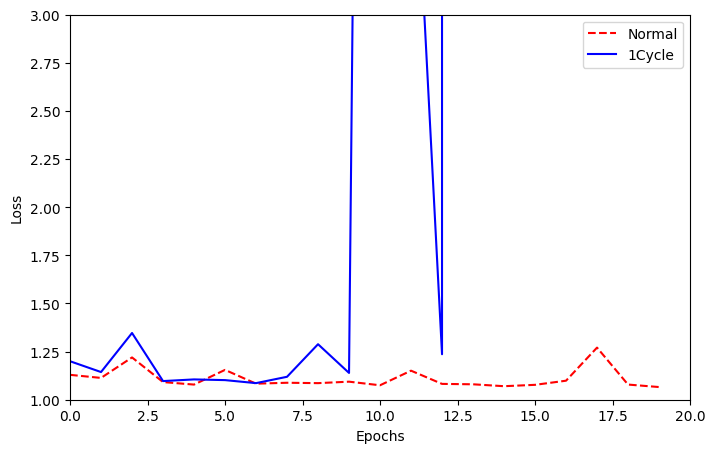

In [44]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(8, 5))

plt.plot(history1.history['val_loss'], 'r--', label='Normal')
plt.plot(history2.history['val_loss'], 'b-', label='1Cycle')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim([0, 20])
plt.ylim([1, 3])
plt.legend()
plt.show()